In [1]:
import sys
sys.path.insert(0, "../../../")


# MNIST Classification

We will build a neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset (a must for everyone working with deep learning).
In this application, we will do this using a _fully connected neural network_ (a.k.a. _multi-layer perceptron_ or _dense neural network_), even though convolutional neural networks would be more appropriate.
We will also introduce the \emph{confusion matrix}, a common graphical tool used to gain insights into the performance of a classification algorithm.


### The MNIST dataset

Recognizing the handwritten digits of the MNIST dataset is a classical benchmark for machine learning. The task consists of recognizing handwritten digits from 0 to 9 in 28x28 pixel images. In the dataset, there are 6 * 10^4 training images and 10^4 test images.


### Training data

To load the mnist dataset, make sure you have downloaded and extracted the `mnist.zip` file. You should find that it contains two folders,

- train
- test

each of which contains png images of handwritten digits of the following form:

- train/0_000000.png
- train/0_000001.png
...
- train/1_000000.png

and so on. The first digit in the filename is the label of the image. The following code finds the paths to all images and checks that there are 60000 training images and 10000 test images.

In [2]:
import os

# make sure to update this path based on your own directory structure
root_path = "mnist"

train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")

train_images_paths = os.listdir(train_path)
test_images_paths = os.listdir(test_path)

print("Number of training images: {}".format(len(train_images_paths)))
print("Number of test images: {}".format(len(test_images_paths)))

Number of training images: 60000
Number of test images: 10000


We can use `matplotlib` to load the images into `numpy` arrays. Since the `mnist` dataset is small enough to be contained in memory, we can load all images at once. For larger datasets, we would need to load the images as needed during training.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

train_images = []
test_images = []

for path in train_images_paths:
    image = plt.imread(os.path.join(train_path, path))
    train_images.append(image)

for path in test_images_paths:
    image = plt.imread(os.path.join(test_path, path))
    test_images.append(image)


print("Shape of training images: {}".format(train_images[0].shape))
print("Shape of test images: {}".format(test_images[0].shape))


Shape of training images: (28, 28)
Shape of test images: (28, 28)


Since the digit is encoded as the first character of the filename, we can extract the ground truth labels from the filenames as follows:

In [4]:
train_ground_truth = []
test_ground_truth = []

for path in train_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    train_ground_truth.append(digit)

for path in test_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    test_ground_truth.append(digit)

print("Number of training ground truth: {}".format(len(train_ground_truth)))
print("Number of test ground truth: {}".format(len(test_ground_truth)))

Number of training ground truth: 60000
Number of test ground truth: 10000


Let us visualize some of the MNIST digits.
By visually inspecting them, we can check that the digits have been correctly imported and that the ground-truth labels are correct.

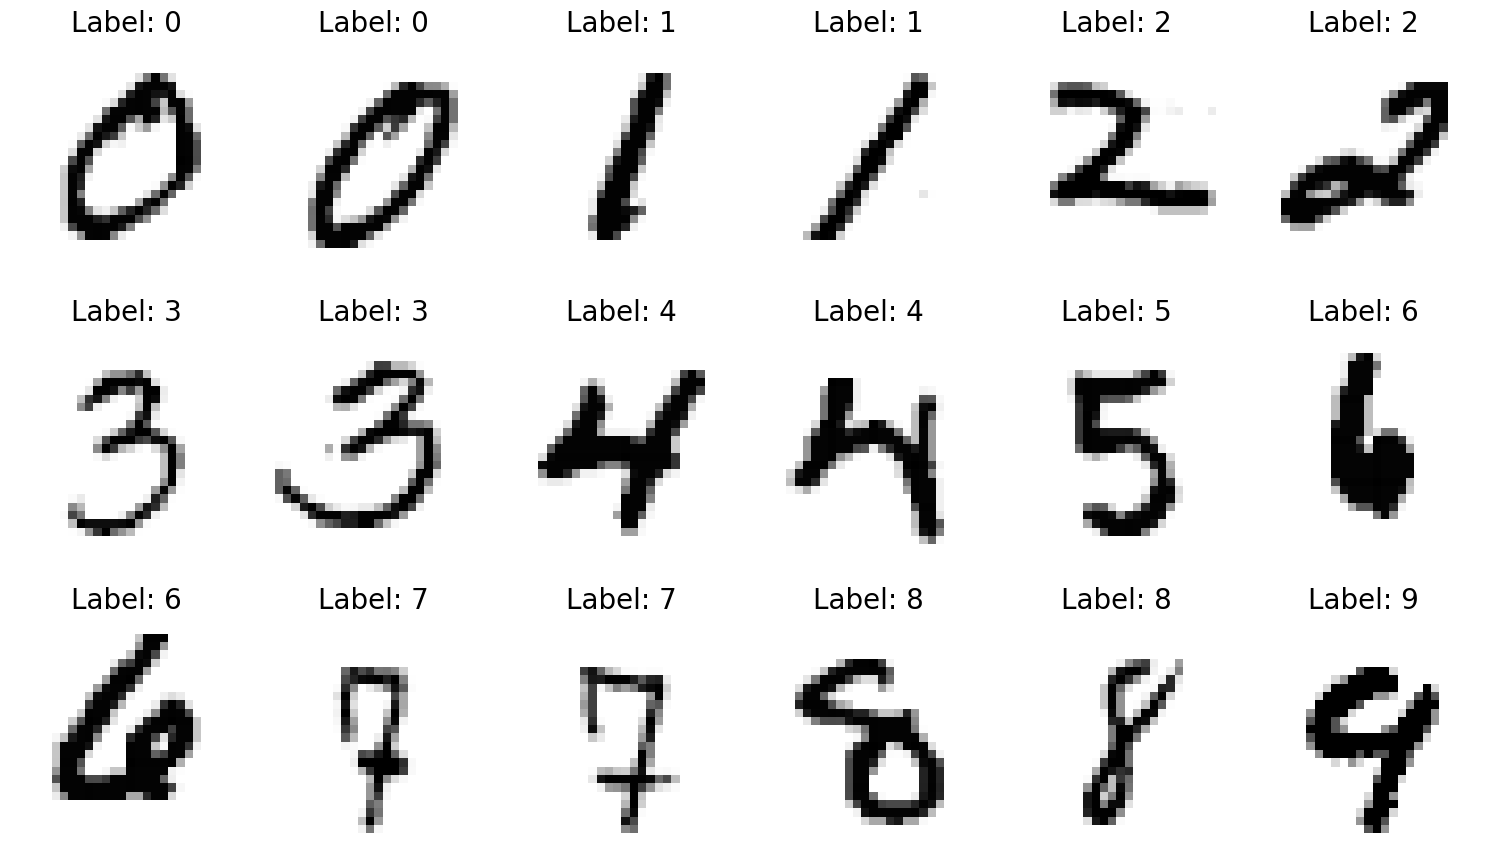

In [5]:
indexes_of_images_to_show = np.linspace(0, 60000, 18, dtype=int, endpoint=False)

plt.figure(figsize=(15, 9))

for i in range(18):
    data_index = indexes_of_images_to_show[i]
    train_image = train_images[data_index]
    train_groundtruth = train_ground_truth[data_index]

    plt.subplot(3, 6, i + 1)
    plt.title(f"Label: {train_groundtruth}", fontsize=20)
    plt.imshow(train_image.squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

## PyTorch Neural network

We will now define the neural network used to classify the digits. There are many modern libraries that make defining and training neural networks much easier (but less instructive!) than doing it from scratch. The main ones are `PyTorch`, `TensorFlow`, and `Keras`. Each has its own advantages. `PyTorch`~and `TensorFlow`~both offer deep low-level access, with `PyTorch`~offering a functional style approach, while `TensorFlow`~has a more object-oriented flavor. In `Keras`~many details are abstracted away, making defining and training networks easier. In this book, we will be using `deeplay`, which **ADD DESCRIPTION**. 
 This will allow us to focus on the concepts rather than the details of the implementation. 

### **Note** We call keras it's own library, but it is actually a part of tensorflow. We should probably clarify this.

We will start with a small _multi-layer perceptron_ (often called also a _fully connected neural network_ or a _dense neural network_) with two hidden layers with 32 neurons each. The output layer will have 10 neurons, one for each digit. Due to the _sigmoid_ activation on the output, the output of the network will be a vector of 10 numbers between 0 and 1, which can be interpreted as probabilities. The predicted digit will be the one with the highest probability. 

We'll create the model from a configuration object with the following parameters:

- `in_features`: the number of input features (28x28=784)
- `hidden_dims`: a list of the number of neurons in each hidden layer (32, 32)
- `out_features`: the number of output features (10)
- `out_activation`: the activation function of the output layer (sigmoid)
- `blocks.activation`: the activation function of the hidden layers (sigmoid)

In [6]:
import deeplay as dl 
from torch.nn import Sigmoid

# Configurations
mlp_config = (
    dl.Config()
    .in_features(28 * 28)
    .hidden_dims([32, 32])
    .out_features(10)
    .out_activation(Sigmoid)
    .blocks.activation(Sigmoid)
)

mlp_model = dl.MultiLayerPerceptron.from_config(mlp_config)

print("Number of parameters:", sum(p.numel() for p in mlp_model.parameters()))
print(mlp_model)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Number of parameters: 26506
MultiLayerPerceptron(
  (in_features): 784
  (hidden_dims): [32, 32]
  (out_features): 10
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (normalization): Identity()
      (activation): Sigmoid()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (normalization): Identity()
      (activation): Sigmoid()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=32, out_features=10, bias=True)
  (out_activation): Sigmoid()
)


Next, we define what we want our model to do. We will use the `Classifier` application class from `deeplay`, which imbues our network with training logic, and adds some convenience metrics such as accuracy.

For this we define another configuration object with the following parameters:

- `model`: the model we just created. We set the model object and merge the configuration object for the model with the configuration object for the application.
- `num_classes`: the number of classes (10)
- `make_target_onehot`: whether to convert the ground truth labels to one-hot vectors (vector of 0s with a 1 at the index of the label). This is necessary to make the output of the network match the ground truth labels.
- `loss`: the loss function to use (Mean Squared Error)
- `optimizer`: the optimizer to use (Stochastic Gradient Descent)

In [7]:
from torch.nn import MSELoss
from torch.optim import SGD

classifier_config = (
    dl.Config()
    .model(dl.MultiLayerPerceptron, mlp_config)
    .num_classes(10)
    .make_target_onehot(True)
    .loss(MSELoss)
    .optimizer(SGD, lr=0.1)
)

classifier = dl.Classifier.from_config(classifier_config)
    
print(classifier)

Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Sigmoid()
  )
  (loss): MSELoss()
  (train_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
  (val_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
)


**Note** the config above is equivalent to:

```python
classifier_config = (
    dl.Config()
    .model(dl.MultiLayerPerceptron)
    .model.in_features(28*28)
    .model.hidden_dims([32, 32])
    .model.out_features(10)
    .model.out_activation(Sigmoid)
    .model.blocks.activation(Sigmoid)
    .num_classes(10)
    .make_targets_onehot(True)
    .loss(MSELoss)
    .optimizer(SGD, lr=0.1)
)
```

#### Dataloaders

To train our classifier, we additionaly need a `DataLoader` and a `Trainer`. `DataLoader` objects handle ensuring the data passed is passed to the network correctly. `Trainer` objects handle more complex training logic, such deciding what hardware to use, running callbacks, saving the model to disk, and much more. 

The simplest way to create a dataloader from data already in memory, is to create a list of `sample, ground_truth` tuples. This can easily be achieved using the python native function `zip`.


In [8]:
train_mnist_image_and_groundtruth = list(zip(train_images, train_ground_truth))
test_mnist_image_and_groundtruth = list(zip(test_images, test_ground_truth))

mnist_train_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, shuffle=True) # Important to shuffle the data, maybe exercise to see what happens if you don't!
mnist_test_dataloader = dl.DataLoader(test_mnist_image_and_groundtruth, shuffle=False)

print("Number of training batches:", len(mnist_train_dataloader))
print("Number of test batches:", len(mnist_test_dataloader))

Number of training batches: 60000
Number of test batches: 10000


#### Trainers

The trainer handles the training and evaluation. It also handles determining when to stop training, utilizing the GPU, saving the model, and logging the training and evaluation metrics. We will start by defining a trainer for our model.

For now, will train for a single `epoch`. An epoch is a single pass through the entire training set. While more epochs may improve performance, in the interest of time, we'll just do a single pass for now. Later in this application, we will demonstrate how to increase the number of epochs without spending more time training.

We will create the trainer with the following arguments:

- `max_epochs`: the maximum number times to iterate over the training data (1)
- `accelerator`: the hardware accelerator to use ("auto" will use a GPU if available, otherwise a CPU)

In [9]:
trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(classifier, mnist_train_dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 26.5 K
1 | loss          | MSELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Let's check the test set. We can reuse the trainer to test the model on the test set:

In [11]:
trainer.test(classifier, mnist_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7085999846458435     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.7085999846458435}]

The _confusion matrix_ can be used to visualize what errors the neural network is making and to gain insights that can help us improve its architecture and training hyperparameters. 

A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem, here 10. 
Each row and column corresponds to one class in the classification problem, ordered arbitrarily but equally for the two axes. 
In this case, we have a natural ordering of the classes, which is the order of the digits. 
An element c_i,j of the confusion matrix represents the number of times the neural network assigned the predicted class j to the actual class i. For example, in our case, c_3,5 would correspond to the number of times the neural network, when given an image depicting the digit 3, classified it as the digit 5. The name stems from the fact that this representation makes it easy to see which classes the model is most commonly confusing. 

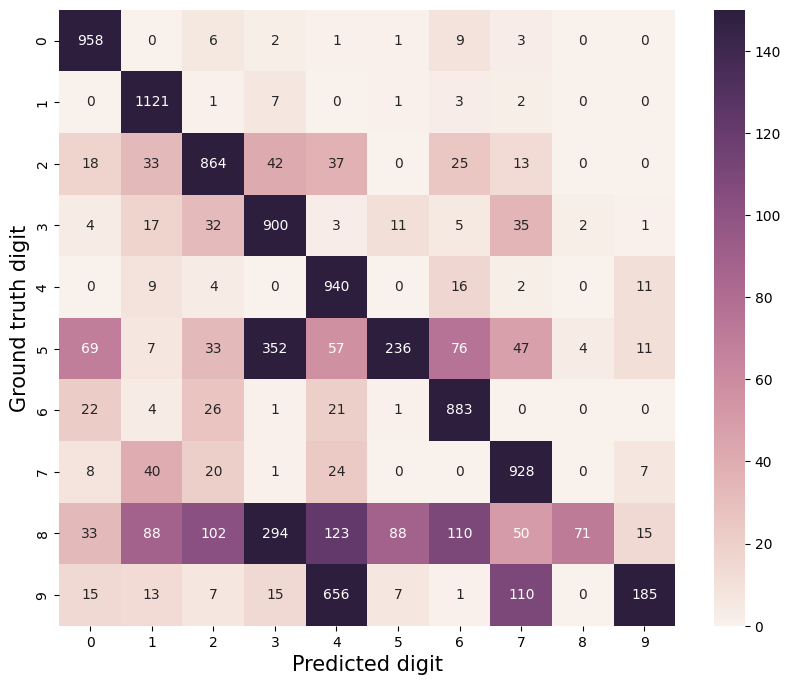

In [12]:
import matplotlib.pyplot as plt
from seaborn import heatmap, cubehelix_palette
from numpy import zeros
trainer.predict
# Compute the confusion matrix
def plot_confusion_matrix(model, trainer, dataloader):
    confusion_matrix = zeros((10, 10), dtype=int)

    for image, groundtruth_digits in dataloader:
        predicted_probabilities = model(image)
        max_probability, predicted_digits = predicted_probabilities.max(dim=1)
        
        # np.add.at is a function that allows us to add values to a numpy array at specific indices
        # Unlike arr[indices] += 1, np.add.at(arr, indices, 1) handles the case where there are duplicate indices.
        # So, arr[[0, 0]] += 1 would result in arr[0] = 1, but np.add.at(arr, [0, 0], 1) results in arr[0] = 2 
        np.add.at(confusion_matrix, (groundtruth_digits, predicted_digits), 1)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap(
        confusion_matrix,
        annot=True, 
        fmt=".0f", 
        square=True, 
        cmap=cubehelix_palette(light=0.95, as_cmap=True),
        vmax=150,
    )
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Ground truth digit", fontsize=15)
    plt.show()
    
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

 Here, we have chosen to assign the `groundtruth_digit` to the second axis and `predicted_digit` to the first axis, but the opposite is also a valid (and comon) choice.

## Neural network improvements

We now start a journey to improve our network and its training, as is usual in developing machine-learning solutions.
We will gradually introduce some new (and fundametal) concepts, to demonstrate how they affect the performance of the trained network, which provide valuable intuition for what hyperparameters are relevant.

#### The choice of output representation

Currently each digit is assigned a probability between 0 and 1 by the network. However, we know that only one classification is true. As such, we can normalize the output such that the prediction sums to one. By doing so, we impose our prior knowledge to reduce the complexity of the problem. This is typically done using what is known as _softmax activation_.

In [13]:
from torch.optim import RMSprop
import torch

classifier_config_with_softmax_out = (
    classifier_config
    .model.out_activation(torch.nn.Softmax, dim=1)
)

classifier = dl.Classifier.from_config(classifier_config_with_softmax_out)
print(classifier)

trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 26.5 K
1 | loss          | MSELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): Sigmoid()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Softmax(dim=1)
  )
  (loss): MSELoss()
  (train_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
  (val_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
)


c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7979999780654907     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.7979999780654907}]

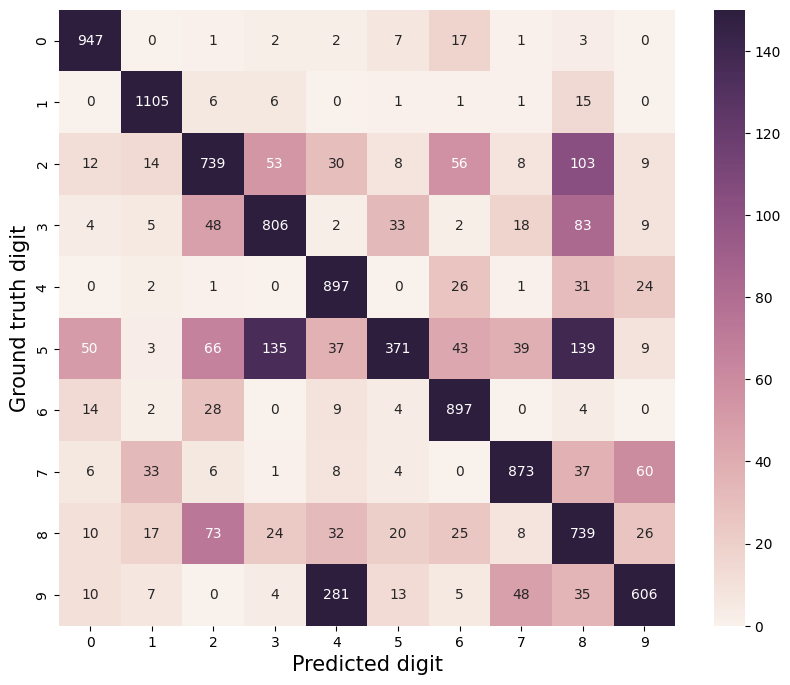

In [14]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

In [15]:
classifier_config_with_relu_internal = (
    classifier_config_with_softmax_out
    .model.blocks.activation(torch.nn.ReLU)
)

classifier = dl.Classifier.from_config(classifier_config_with_relu_internal)
print(classifier)

trainer = dl.Trainer(
    max_epochs=1,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 26.5 K
1 | loss          | MSELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Softmax(dim=1)
  )
  (loss): MSELoss()
  (train_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
  (val_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.9315000176429749     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.9315000176429749}]

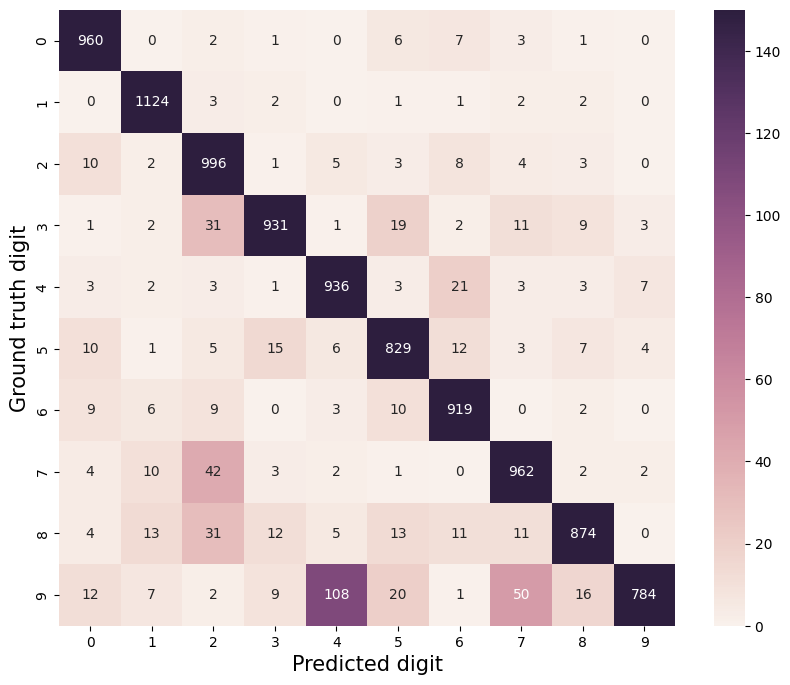

In [16]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

#### Mini batches

Let us we will introduce our next improvement: _mini-batches_. Mini-batches are a way to train neural networks using only a subset of the training data at each iteration. This is done by splitting the training data into smaller subsets called _mini-batches_. The neural network is then trained on each mini-batch in turn, and the parameters are updated after each mini-batch. In fact, we were already using mini-batches, but we were using a batch size of one. The batch size is a hyperparameter that can be tuned to improve the performance of the neural network. In general, larger batches can lead to faster training since more data is processed at once, but it demands more memory and might not always lead to better convergence. Moreover, while larger batches yield a better estimate of the local gradient, this does not necessarily correlate to allowing a larger weight update if the optimization landscape is rough. On the other hand, smaller batches can offer a regular update to the model and often lead to a more robust convergence, but the training might be slower due to the overhead of frequent updates. Thus, neither bigger nor smaller batches are universally superior; it's a balance of factors like memory constraints, convergence behavior, and training speed. As a rule of thumb, a batch size of `32` is a good starting point. Rarely are batches smaller than `8` or larger than `256` used.

We set our batch size in our dataloaders. They will handle splitting the data into mini-batches for us. We will use a batch size of `16` for both the training and validation dataloaders. Moreover, since we are now using mini-batches, we can increase the number of epochs to `10` to compensate for the smaller batch size without significantly increasing the total training time.

In [17]:
mnist_test_dataloader = dl.DataLoader(test_mnist_image_and_groundtruth, batch_size=16, shuffle=False)
mnist_train_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, batch_size=16, shuffle=True)

#### The choice of optimizer

Using plain _stochastic gradient descent_ for updating weights is straightforward, but generally not optimal. 
Modern deep learning almost universally uses extensions such as _root mean squared propagation_ (RMSprop) or _Adam_. The main advantages of these alternatives are that they change the learning rate for each weight individually during training. Each algorithm has its own way of doing so, but it is common to use some type of _momentum_. For example, a weight that is updated in the same direction multiple times in a row will take larger steps at each iteration, while a weight that changes direction frequently will take smaller steps. To better utilize our increased batch size, we will use the `RMSprop` optimizer 

In [18]:

config_with_rmsprop = (
    classifier_config_with_relu_internal
    .optimizer(RMSprop, lr=0.001)
)

classifier = dl.Classifier.from_config(config_with_rmsprop)
print(classifier)

trainer = dl.Trainer(
    max_epochs=10,
    accelerator="auto", 
)

trainer.fit(classifier, mnist_train_dataloader)
trainer.test(classifier, mnist_test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 26.5 K
1 | loss          | MSELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (make_target_onehot): True
  (model): MultiLayerPerceptron(
    (in_features): 784
    (hidden_dims): [32, 32]
    (out_features): 10
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=32, out_features=10, bias=True)
    (out_activation): Softmax(dim=1)
  )
  (loss): MSELoss()
  (train_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
  (val_metrics): ModuleList(
    (0): MulticlassAccuracy()
  )
)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.9621000289916992     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.9621000289916992}]

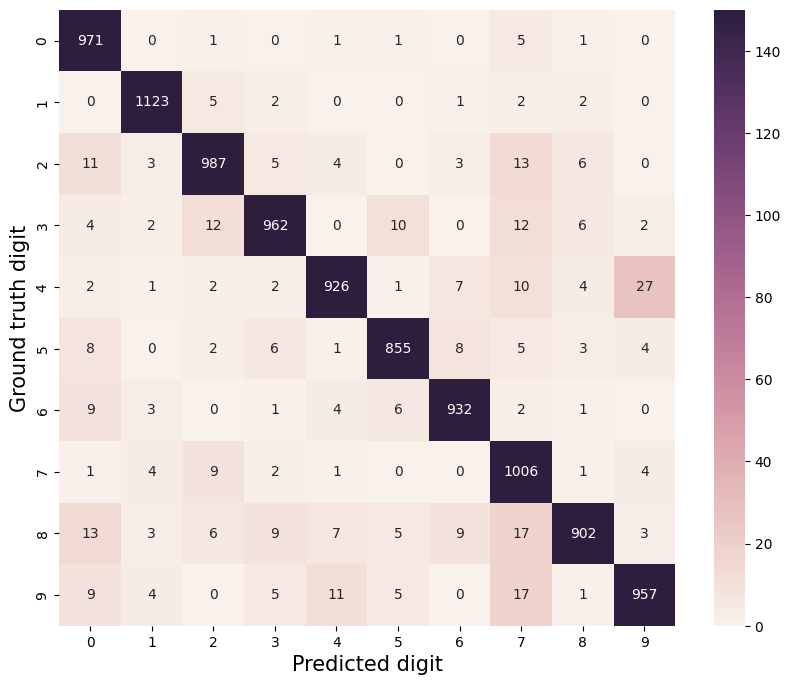

In [19]:
plot_confusion_matrix(classifier, trainer, mnist_test_dataloader)

### Error analysis

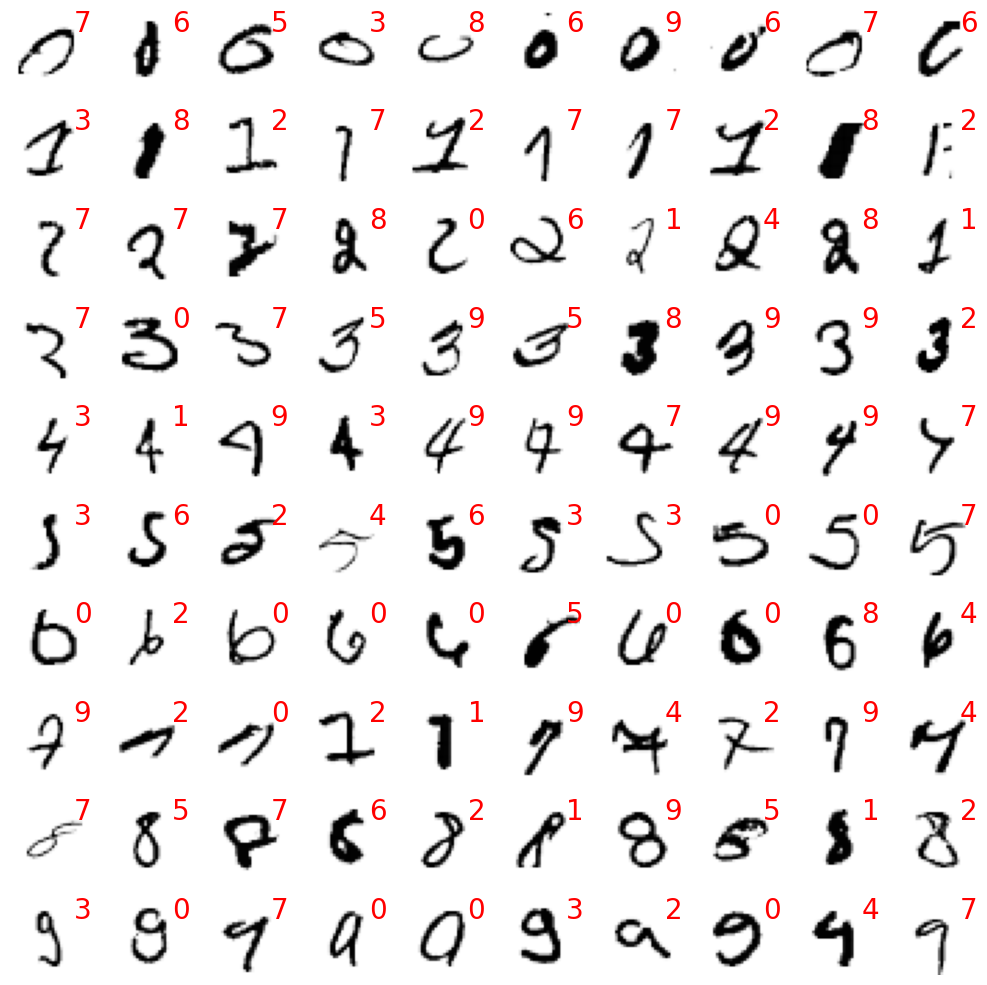

In [20]:
mnist_test_dataloader = dl.DataLoader(train_mnist_image_and_groundtruth, batch_size=1, shuffle=False)

number_of_images_per_digit_to_show = 10
num_incorrect_predictions_per_digit = np.zeros(10, int)

plt.figure(figsize=(10, number_of_images_per_digit_to_show))

for image, groundtruth_digits in mnist_test_dataloader:
    groundtruth_digits = int(groundtruth_digits)

    if num_incorrect_predictions_per_digit[groundtruth_digits] >= number_of_images_per_digit_to_show:
        continue

    predicted_probabilities = classifier(image)
    max_probability, predicted_digits = predicted_probabilities.max(dim=1)
    if predicted_digits == groundtruth_digits:
        continue 

    num_incorrect_predictions_per_digit[groundtruth_digits] += 1

    subplot_idx = groundtruth_digits * number_of_images_per_digit_to_show + num_incorrect_predictions_per_digit[groundtruth_digits]
    plt.subplot(10, number_of_images_per_digit_to_show, subplot_idx)
    plt.imshow(image.squeeze(), cmap="Greys")
    plt.annotate(str(int(predicted_digits)), (0.8, 1), (1, 1), xycoords="axes fraction", textcoords="offset points", va="top", ha="left", fontsize=20, color="red")
    plt.axis("off")

    if (num_incorrect_predictions_per_digit >= number_of_images_per_digit_to_show).all():
        break

plt.tight_layout()
plt.show()